In [49]:
#imported neccesay libraries
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import statsmodels.graphics.tsaplots as snt
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
import math  

import datetime as dt
from datetime import datetime

from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, TensorBoard

%matplotlib inline

In [50]:
#imported dataset
data = pd.read_csv('/content/bicoin_data.csv', index_col=['datetime'])
data = data.drop('Unnamed: 0', axis=1) #removed unusqal column
data.head()

,open,high,low,close
datetime,,,,
2021-10-02 14:40:00,47893.92969,47981.64062,47889.07812,47981.64062
2021-10-02 14:45:00,47926.17188,47959.01172,47898.03125,47942.94141
2021-10-02 14:50:00,47956.17969,48095.00000,47950.66016,48095.00000
2021-10-02 14:55:00,48060.30859,48100.98828,48006.01172,48011.07812
2021-10-02 15:00:00,47966.01172,48015.01953,47952.35938,47957.01172


In [51]:
data.shape  #shape

(5000, 4)

In [52]:
scaler=MinMaxScaler()
scaled_data=scaler.fit_transform(data['close'].values.reshape(-1,1)) #willl be changed into 2 dimension within the range of (0,1)
scaled_data

array([[0.05468166],
       [0.05245565],
       [0.06120219],
       ...,
       [0.98960243],
       [0.99192057],
       [0.99045221]])

In [53]:
time_intervals_to_train = 24   # as we have taken 5 min interval then 12*2=24 interval for 2hrs
prediction_interval=12  # we have to predict for next 1 hr----> 12*1=12 

x_train=[]
y_train=[]

In [54]:
#i will train data for 24 interval and i will predict data after 12 interval------> predict 36th from 1 to 24 index data
for i in range(time_intervals_to_train,len(scaled_data)-prediction_interval):
  x_train.append(scaled_data[i - time_intervals_to_train: i,0])
  y_train.append(scaled_data[i + prediction_interval,0])

x_train=np.array(x_train)
y_train=np.array(y_train)

In [55]:
x_train

array([[0.05468166, 0.05245565, 0.06120219, ..., 0.04183721, 0.05297603,
        0.05176292],
       [0.05245565, 0.06120219, 0.05637493, ..., 0.05297603, 0.05176292,
        0.05326543],
       [0.06120219, 0.05637493, 0.05326498, ..., 0.05176292, 0.05326543,
        0.0533225 ],
       ...,
       [0.9875755 , 0.98127292, 0.97623647, ..., 0.97492023, 0.97239696,
        0.97239404],
       [0.98127292, 0.97623647, 0.98125337, ..., 0.97239696, 0.97239404,
        0.97191881],
       [0.97623647, 0.98125337, 0.97339076, ..., 0.97239404, 0.97191881,
        0.98182274]])

In [56]:
y_train

array([0.04595983, 0.0487287 , 0.04836178, ..., 0.98960243, 0.99192057,
       0.99045221])

In [57]:
print(x_train.shape)
print(y_train.shape)

(4964, 24)
(4964,)


Create The LSTM model

In [58]:
# Import Libraries and packages from Keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout


In [59]:
#we have added LSTM layers
model= Sequential()  #sequencial model
model.add(LSTM(128, return_sequences=True, input_shape=(x_train.shape[1],1),activation='relu')) #add lstm layer
model.add(Dropout(0.3))                                                                         #add dropout layer
model.add(LSTM(64, return_sequences=True, activation= 'relu'))                                  #add lstm layer
model.add(Dropout(0.2))                                                                         #add dropout layer     
model.add(LSTM(32, activation='relu'))                                                          #LSTM layer
model.add(Dropout(0.2))                                                                         #dropout layer
model.add(Dense(1,activation='sigmoid'))                                                        #final layer with one unit

In [60]:
model.compile(loss='mean_squared_error',optimizer='adam',metrics=['accuracy'])                  #model comilations

In [61]:
%%time
es = EarlyStopping(monitor='val_loss', min_delta=1e-10, patience=10, verbose=1)               #early stopping criteria
rlr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, verbose=1)               
mcp = ModelCheckpoint(filepath='weights.h5', monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=True)

tb = TensorBoard('logs')

history = model.fit(x_train, y_train, shuffle=False, epochs=100, callbacks=[es, rlr, mcp, tb], validation_split=0.2, verbose=1, batch_size=256)

Epoch 1/100
16/16 [==============================] - ETA: 0s - loss: 0.0601 - accuracy: 2.5183e-04
Epoch 1: val_loss improved from inf to 0.14696, saving model to weights.h5
16/16 [==============================] - 8s 268ms/step - loss: 0.0601 - accuracy: 2.5183e-04 - val_loss: 0.1470 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 2/100
16/16 [==============================] - ETA: 0s - loss: 0.0529 - accuracy: 2.5183e-04
Epoch 2: val_loss improved from 0.14696 to 0.13128, saving model to weights.h5
16/16 [==============================] - 4s 236ms/step - loss: 0.0529 - accuracy: 2.5183e-04 - val_loss: 0.1313 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 3/100
16/16 [==============================] - ETA: 0s - loss: 0.0525 - accuracy: 2.5183e-04
Epoch 3: val_loss improved from 0.13128 to 0.12931, saving model to weights.h5
16/16 [==============================] - 4s 236ms/step - loss: 0.0525 - accuracy: 2.5183e-04 - val_loss: 0.1293 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 4/100
16

Test Data

In [62]:
#for test data
test_start='2021-10-20 00:00:00'
test_end='2021-10-23 00:00:00'
symbol='BTC/USD'
api_key='61a8c16b48214b219374ac7cdedd419b'
order='asc'
interval='5min'
test_api_url=f"https://api.twelvedata.com/time_series?symbol={symbol}&start_date={test_start}&end_date={test_end}&interval={interval}&order={order}&apikey={api_key}"

In [63]:
import requests

In [64]:
test_data=requests.get(test_api_url).json()
test_data_final=pd.DataFrame(test_data['values'])

In [65]:
test_data_final.head()

,datetime,open,high,low,close
0,2021-10-20 00:00:00,64268.39844,64342.85938,64238.05078,64250.01172
1,2021-10-20 00:05:00,64197.19922,64197.19922,64086.75000,64140.62891
2,2021-10-20 00:10:00,64157.37891,64183.78906,64157.37891,64170.85156
3,2021-10-20 00:15:00,64179.98828,64218.92969,64105.01172,64125.21875
4,2021-10-20 00:20:00,64152.80078,64156.87891,64111.67969,64111.67969


In [66]:
bitcoin_prices=pd.to_numeric(test_data_final['close'],errors='coerce').values       # actual bitcoin prices

In [67]:
len(bitcoin_prices)

855

In [68]:
#prepared test data after transformations
test_inputs=test_data_final['close'].values
test_inputs= test_inputs.reshape(-1,1)
model_inputs=scaler.fit_transform(test_inputs)

In [69]:
# we are predicting data and in input we are takeing 2 hrs of data
x_test=[]

for x in range(time_intervals_to_train,len(model_inputs)):
  x_test.append(model_inputs[x-time_intervals_to_train:x,0])

x_test=np.array(x_test)

In [70]:
x_test=np.reshape(x_test,(x_test.shape[0],x_test.shape[1],1)) #changed into 3 dim bcs LSTM works on 3 dim modal
x_test.shape

(831, 24, 1)

In [71]:
prediction=model.predict(x_test)  # predicted test_data
prediction=scaler.inverse_transform(prediction)  # again we have inverse transformed prediction 
prediction.shape

(831, 1)

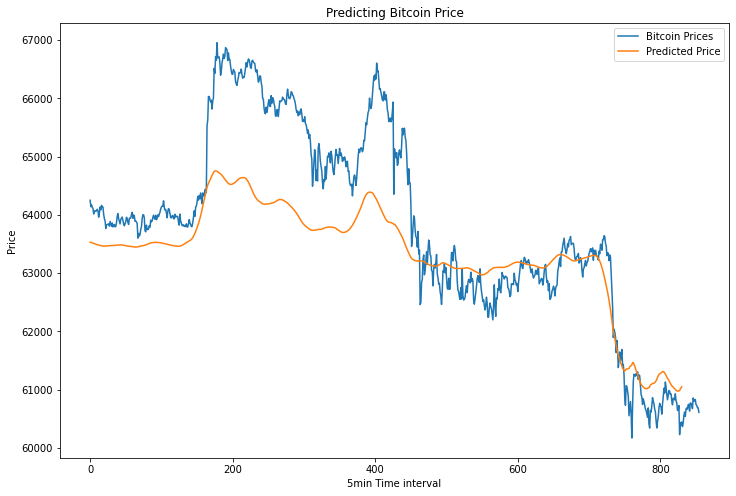

In [72]:
# visualised predicted and actual prices of Bitcoin
plt.figure(figsize=(12,8))
plt.plot(bitcoin_prices,label='Bitcoin Prices')
plt.plot(prediction,label='Predicted Price')
plt.title('Predicting Bitcoin Price')
plt.xlabel('5min Time interval')
plt.ylabel('Price')
plt.legend()
plt.show()

In [73]:
# made a single dataferame for Actual and Predicted Prices of Bitcoin
bitcoin=pd.DataFrame(bitcoin_prices[:len(prediction)],index=test_data_final['datetime'][:len(prediction)])
pred=pd.DataFrame(prediction,index=test_data_final['datetime'][:len(prediction)])
q= pd.concat([bitcoin,pred],axis=1)
q.columns=['Actual Prices','Predicted Prices']

In [77]:
q.head()  #first five rows of q

,Actual Prices,Predicted Prices
datetime,,
2021-10-20 00:00:00,64250.01172,63530.160156
2021-10-20 00:05:00,64140.62891,63526.558594
2021-10-20 00:10:00,64170.85156,63523.085938
2021-10-20 00:15:00,64125.21875,63519.003906
2021-10-20 00:20:00,64111.67969,63514.750000


In [75]:
#Forecast bias
forecast_errors = [q['Actual Prices'][i]- q['Predicted Prices'][i] for i in range(len(q))]      # difference of actual and predicted prices
bias = sum(forecast_errors) * 1.0/len(q)       # bias
print('Bias: %f' % bias)
print('Mean absolute error:', mean_absolute_error(q['Actual Prices'].values, q['Predicted Prices'].values))    # mean absolute error of Bitcoin prices
print('Mean squared error:', mean_squared_error(q['Actual Prices'].values, q['Predicted Prices'].values))      # mean squared error of Bitcoin prices
print('Root mean squared error:', math.sqrt(mean_squared_error(q['Actual Prices'].values, q['Predicted Prices'].values)))  # root mean error of Bitcoin prices

Bias: 556.858839
Mean absolute error: 766.8798793667269
Mean squared error: 1029957.7663224374
Root mean squared error: 1014.8683492564134


We can see that we have find these errors and these are not too haivy errors. so we can say that our model is performing quit good.